Fonte: https://www.kaggle.com/code/luisacavalcante/binary-random-forest/edit

First, we import the libraries.

In [ ]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inside motion_data_train, we have: AccX, AccY, AccZ, GyroX, GyroY, GyroZ, Class

In [ ]:
kaglr_train_motion_data_path = '/content/drive/My Drive/hackaton/train_motion_data.csv'
motion_data_train = pd.read_csv(kaglr_train_motion_data_path)
#3644 linhas
kaglr_test_motion_data_path='/content/drive/My Drive/hackaton/test_motion_data.csv'
motion_data_test = pd.read_csv(kaglr_test_motion_data_path)
#3084 linhas
print(motion_data_train.columns)
print(motion_data_test.columns)


Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')
Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')


Since we also want to capture newer features, we insert a "dummy" columns regarding one of these features.


Specifically, we want to analyze the "Weather" attribute.

In [ ]:
# Define the initial value and variation magnitude
initial_value = 0.5  # Starting value
variation_magnitude = 0.02  # Adjust this value to control the amount of variation

# Create a list to store the random variations
variations = np.random.uniform(low=-variation_magnitude, high=variation_magnitude, size=len(motion_data_train))

# Create a new column with cumulative variations
motion_data_train['Humidity'] = initial_value + np.cumsum(variations)

# Define the initial value and variation magnitude
initial_value = 0.5  # Starting value
variation_magnitude = 0.02  # Adjust this value to control the amount of variation

# Create a list to store the random variations
variations = np.random.uniform(low=-variation_magnitude, high=variation_magnitude, size=len(motion_data_test))

# Create a new column with cumulative variations
motion_data_test['Humidity'] = initial_value + np.cumsum(variations)

Now we have the data in the following format:

In [ ]:
motion_data_train

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp,Humidity
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629,0.487779
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630,0.476939
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630,0.488157
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631,0.482882
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631,0.476399
...,...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,SLOW,3583789,0.933834
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,SLOW,3583790,0.933016
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,SLOW,3583790,0.918844
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,SLOW,3583791,0.936822


In [ ]:
np.array(motion_data_train.iloc[0].values.tolist())

array(['0.0', '0.0', '0.0', '0.059406646', '-0.17470746', '0.101938136',
       'NORMAL', '3581629', '0.4877793472836387'], dtype='<U32')

The values from the sensor are standard.

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data using the scaler
motion_data_train['Humidity'] = scaler.fit_transform(motion_data_train[['Humidity']])
motion_data_test['Humidity'] = scaler.fit_transform(motion_data_test[['Humidity']])

# Define the minimum and maximum values for the new range
new_min = 0
new_max = 4095

# Scale the column
motion_data_train['Humidity'] = (motion_data_train['Humidity'] * (new_max - new_min)) + new_min
motion_data_test['Humidity'] = (motion_data_test['Humidity'] * (new_max - new_min)) + new_min

We separate by attributes:

In [ ]:
X = motion_data_train[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Humidity']]
#X = motion_data_train[['AccX', 'AccY', 'AccZ']]
Y = motion_data_train['Class']

# Print the contents of X and Y
print("X:")
print(X.describe())  # Print the first few rows of X
print("\nY:")
print(Y.describe())  # Print the first few rows of Y

# Print the contents of X and Y
#print("X:")
#print(X.head())  # Print the first few rows of X
#print("\nY:")
#print(Y.head())  # Print the first few rows of Y

X:
              AccX         AccY         AccZ        GyroX        GyroY  \
count  3644.000000  3644.000000  3644.000000  3644.000000  3644.000000   
mean      0.040467    -0.073418     0.008271     0.001593    -0.001273   
std       0.985653     0.903408     0.985061     0.066918     0.126205   
min      -4.636523    -4.699795    -7.143998    -0.751822    -1.587028   
25%      -0.550695    -0.592540    -0.558464    -0.028558    -0.053756   
50%       0.003931    -0.080833     0.002262     0.001985    -0.001833   
75%       0.595987     0.452401     0.556157     0.031918     0.051313   
max       4.985548     4.245151     5.171739     0.849255     1.679879   

             GyroZ     Humidity  
count  3644.000000  3644.000000  
mean      0.007949  2087.253100  
std       0.115687   940.668370  
min      -1.236468     0.000000  
25%      -0.029398  1318.595983  
50%       0.002978  2159.580888  
75%       0.040852  2721.958677  
max       1.190500  4095.000000  

Y:
count     3644
uniqu

Now we plot each attribute:

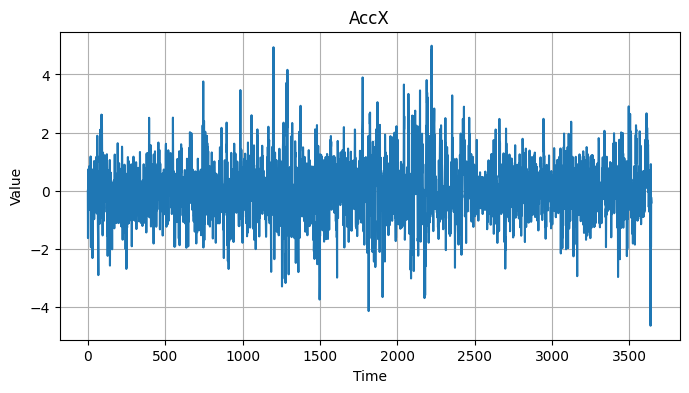

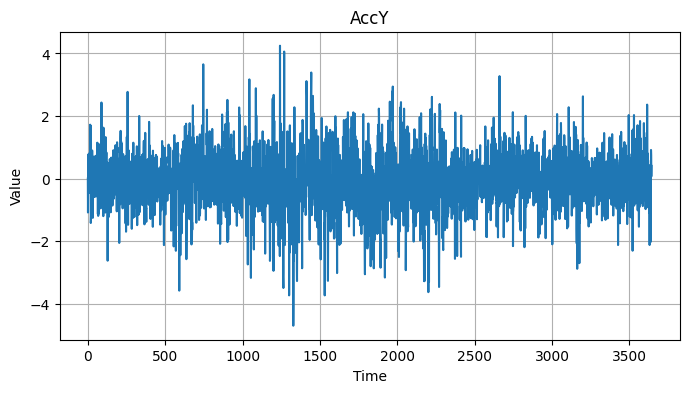

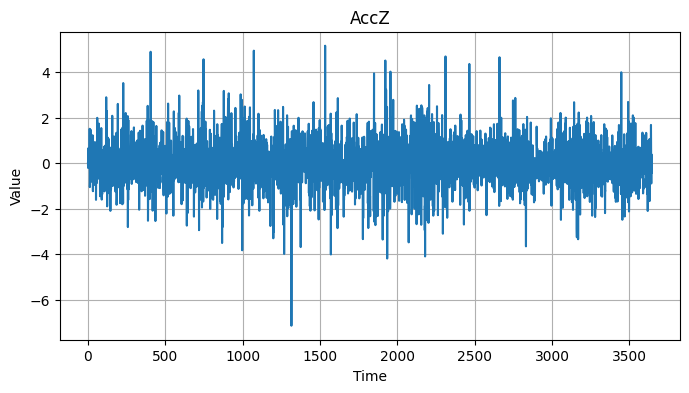

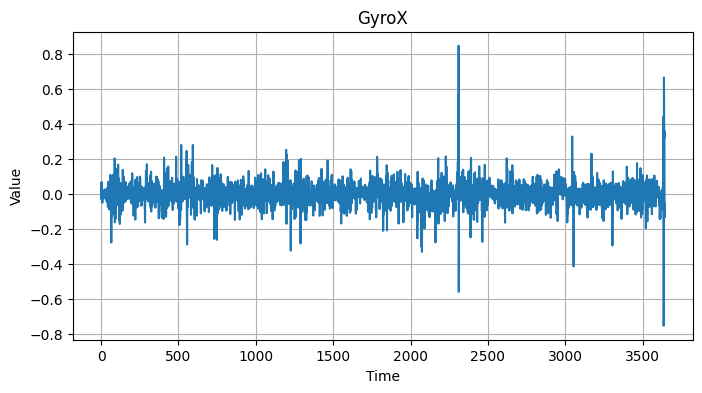

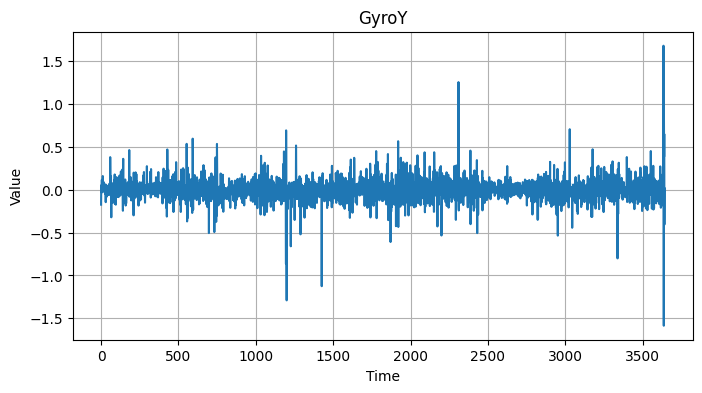

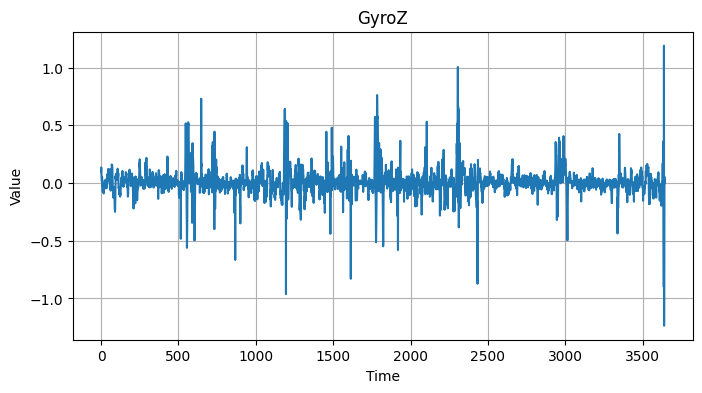

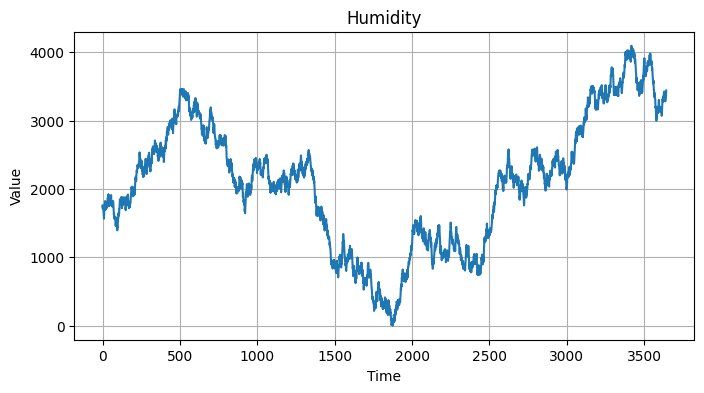

In [ ]:

# Plotting each feature separately
for column in X.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(X[column])
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

The training data is divided as follows: Normal: 1-1200, Aggressive: 1201-2314, Slow: 2315-3645. This means that we don't need to worry about the temporal separation of normal, aggressive, and slow data. We can analyze them as if they were collected continuously.



---



Now we separate between groups (dangerous, slow and normals)

In [ ]:
motion_data_train_normal = motion_data_train.loc[motion_data_train['Class'] == 'NORMAL']
motion_data_train_slow = motion_data_train.loc[motion_data_train['Class'] == 'SLOW']
motion_data_train_aggressive = motion_data_train.loc[motion_data_train['Class'] == 'AGGRESSIVE']

motion_data_test_normal = motion_data_test.loc[motion_data_test['Class'] == 'NORMAL']
motion_data_test_slow = motion_data_test.loc[motion_data_test['Class'] == 'SLOW']
motion_data_test_aggressive = motion_data_test.loc[motion_data_test['Class'] == 'AGGRESSIVE']

train_slow_samples = motion_data_train_slow.__len__()
train_normal_samples = motion_data_train_normal.__len__()
train_aggressive_samples = motion_data_train_aggressive.__len__()

test_slow_samples = motion_data_test_slow.__len__()
test_normal_samples = motion_data_test_normal.__len__()
test_aggressive_samples = motion_data_test_aggressive.__len__()


print('---Test---')
print("Total: "+ str(motion_data_test.__len__()))
print('Slow samples: ' + str(test_slow_samples))
print('Normal samples: ' + str(test_normal_samples))
print('Aggressive samples: ' + str(test_aggressive_samples))

print('---Train---')
print("Total: "+ str(motion_data_train.__len__()))
print('Slow samples: ' + str(train_slow_samples))
print('Normal samples: ' + str(train_normal_samples))
print('Aggressive samples: ' + str(train_aggressive_samples))

---Test---
Total: 3084
Slow samples: 1273
Normal samples: 997
Aggressive samples: 814
---Train---
Total: 3644
Slow samples: 1331
Normal samples: 1200
Aggressive samples: 1113


We show how the accelaration baheves



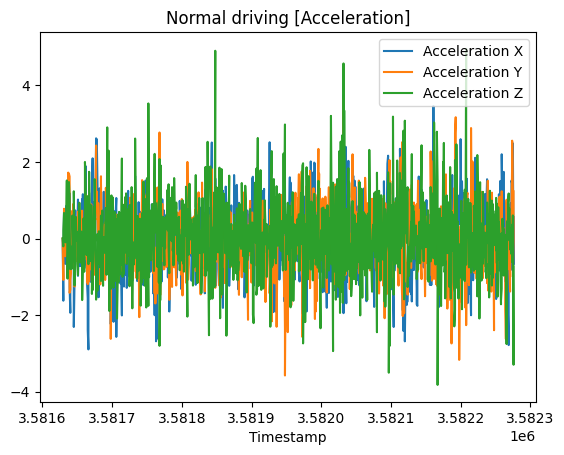

In [ ]:
# Normal driving behavior's acceleration
import matplotlib.pyplot as plt

plt.plot(motion_data_train_normal['Timestamp'], motion_data_train_normal['AccX'], label='Acceleration X')
plt.plot(motion_data_train_normal['Timestamp'], motion_data_train_normal['AccY'], label='Acceleration Y')
plt.plot(motion_data_train_normal['Timestamp'], motion_data_train_normal['AccZ'], label='Acceleration Z')

plt.title('Normal driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

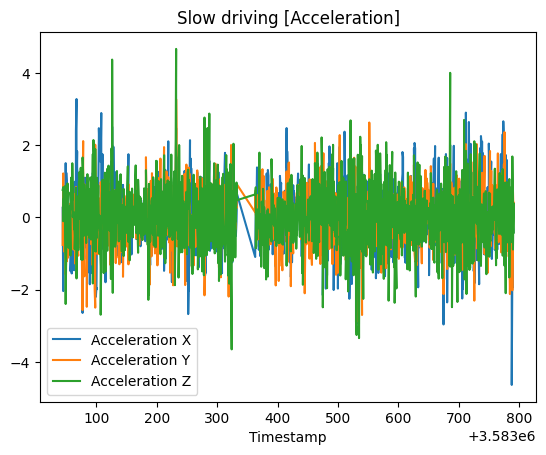

In [ ]:
# Slow driving behavior's acceleration
import matplotlib.pyplot as plt

plt.plot(motion_data_train_slow['Timestamp'], motion_data_train_slow['AccX'], label='Acceleration X')
plt.plot(motion_data_train_slow['Timestamp'], motion_data_train_slow['AccY'], label='Acceleration Y')
plt.plot(motion_data_train_slow['Timestamp'], motion_data_train_slow['AccZ'], label='Acceleration Z')

plt.title('Slow driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

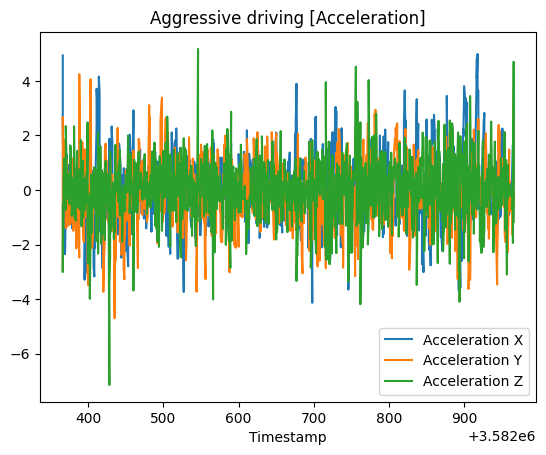

In [ ]:
# Aggresive driving behavior's acceleration
import matplotlib.pyplot as plt

plt.plot(motion_data_train_aggressive['Timestamp'], motion_data_train_aggressive['AccX'], label='Acceleration X')
plt.plot(motion_data_train_aggressive['Timestamp'], motion_data_train_aggressive['AccY'], label='Acceleration Y')
plt.plot(motion_data_train_aggressive['Timestamp'], motion_data_train_aggressive['AccZ'], label='Acceleration Z')

plt.title('Aggressive driving [Acceleration]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

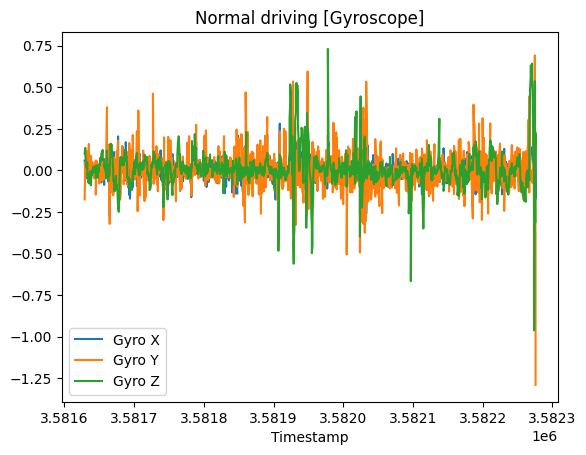

In [ ]:
# Normal driving behavior's gyroscope orientation
import matplotlib.pyplot as plt

plt.plot(motion_data_train_normal['Timestamp'], motion_data_train_normal['GyroX'], label='Gyro X')
plt.plot(motion_data_train_normal['Timestamp'], motion_data_train_normal['GyroY'], label='Gyro Y')
plt.plot(motion_data_train_normal['Timestamp'], motion_data_train_normal['GyroZ'], label='Gyro Z')

plt.title('Normal driving [Gyroscope]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

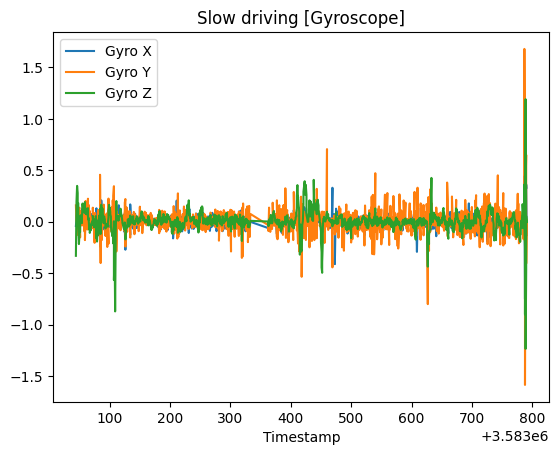

In [ ]:
# Slow driving behavior's gyroscope orientation
import matplotlib.pyplot as plt

plt.plot(motion_data_train_slow['Timestamp'], motion_data_train_slow['GyroX'], label='Gyro X')
plt.plot(motion_data_train_slow['Timestamp'], motion_data_train_slow['GyroY'], label='Gyro Y')
plt.plot(motion_data_train_slow['Timestamp'], motion_data_train_slow['GyroZ'], label='Gyro Z')

plt.title('Slow driving [Gyroscope]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

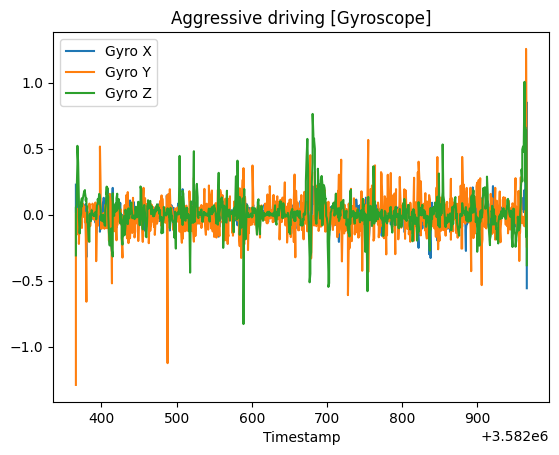

In [ ]:
# Agressive driving behavior's gyroscope orientation
import matplotlib.pyplot as plt

plt.plot(motion_data_train_aggressive['Timestamp'], motion_data_train_aggressive['GyroX'], label='Gyro X')
plt.plot(motion_data_train_aggressive['Timestamp'], motion_data_train_aggressive['GyroY'], label='Gyro Y')
plt.plot(motion_data_train_aggressive['Timestamp'], motion_data_train_aggressive['GyroZ'], label='Gyro Z')

plt.title('Aggressive driving [Gyroscope]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

According to the graphs from the gyroscope in the last 3 types of direction, we see that there is noise. That's we why consider the first and last 5 seconds(10 readings)


In [ ]:
#motion_data_train.describe
motion_data_train_normal.describe
#motion_data_train_slow.describe
#motion_data_train_aggressive.describe

<bound method NDFrame.describe of           AccX      AccY      AccZ     GyroX     GyroY     GyroZ   Class  \
0     0.000000  0.000000  0.000000  0.059407 -0.174707  0.101938  NORMAL   
1    -1.624864 -1.082492 -0.204183 -0.028558  0.051313  0.135536  NORMAL   
2    -0.594660 -0.122410  0.220502 -0.019395 -0.029322  0.087888  NORMAL   
3     0.738478 -0.228456  0.667732  0.069791 -0.029932  0.054902  NORMAL   
4     0.101741  0.777568 -0.066730  0.030696 -0.003665  0.054902  NORMAL   
...        ...       ...       ...       ...       ...       ...     ...   
1195 -0.820672  2.556599 -0.617599 -0.031612 -0.865596 -0.962189  NORMAL   
1196 -0.016871  1.171574  0.603792  0.253662  0.692110  0.537485  NORMAL   
1197  2.488864 -1.001262  0.432143  0.140041 -0.080023  0.051847  NORMAL   
1198 -0.680338 -0.048300 -3.298533 -0.169057 -0.383012  0.217392  NORMAL   
1199  0.563353  1.234707 -0.729512  0.226784 -1.290758 -0.309174  NORMAL   

      Timestamp     Humidity  
0       3581629  1756.

In [ ]:
N_RECORDS = 10

# A solution would be to just remove the first and last N samples
motion_data_train_slow_clean = motion_data_train_slow.iloc[N_RECORDS:]
motion_data_train_slow_clean = motion_data_train_slow_clean.iloc[:-N_RECORDS]
motion_data_test_slow_clean = motion_data_test_slow.iloc[N_RECORDS:]
motion_data_test_slow_clean = motion_data_test_slow_clean.iloc[:-N_RECORDS]
motion_data_train_normal_clean = motion_data_train_normal.iloc[N_RECORDS:]
motion_data_train_normal_clean = motion_data_train_normal_clean.iloc[:-N_RECORDS]
motion_data_test_normal_clean = motion_data_test_normal.iloc[N_RECORDS:]
motion_data_test_normal_clean = motion_data_test_normal_clean.iloc[:-N_RECORDS]
motion_data_train_aggressive_clean = motion_data_train_aggressive.iloc[N_RECORDS:]
motion_data_train_aggressive_clean = motion_data_train_aggressive_clean.iloc[:-N_RECORDS]
motion_data_test_aggressive_clean = motion_data_test_aggressive.iloc[N_RECORDS:]
motion_data_test_aggressive_clean = motion_data_test_aggressive_clean.iloc[:-N_RECORDS]

In [ ]:
#motion_data_train_clean.describe
#motion_data_train_normal_clean.describe
#motion_data_train_slow_clean.describe
motion_data_train_aggressive_clean.describe

<bound method NDFrame.describe of           AccX      AccY      AccZ     GyroX     GyroY     GyroZ       Class  \
1210  1.314181 -0.445990  0.679180 -0.029780  0.048869 -0.133856  AGGRESSIVE   
1211  0.349967 -0.278574 -0.314822  0.072846  0.014661 -0.062995  AGGRESSIVE   
1212  0.427971 -1.341067  0.236822 -0.031612 -0.017104 -0.025733  AGGRESSIVE   
1213 -0.512740 -0.963006  0.577825 -0.055436 -0.064752  0.010919  AGGRESSIVE   
1214 -0.692946 -1.238642 -0.025652  0.061239 -0.073304  0.092775  AGGRESSIVE   
...        ...       ...       ...       ...       ...       ...         ...   
2298 -0.589566 -1.147603 -0.212941  0.055131  0.003054  0.279089  AGGRESSIVE   
2299 -0.552176 -0.125592  0.219416  0.039859 -0.019548  0.342619  AGGRESSIVE   
2300 -0.907746  1.483183 -0.219600  0.064294 -0.065363  0.252211  AGGRESSIVE   
2301 -0.353759  0.420975 -0.037458  0.091783 -0.062308  0.493503  AGGRESSIVE   
2302 -0.509053  0.276685 -0.141376  0.122326 -0.050091  0.516105  AGGRESSIVE   

     

In [ ]:
motion_data_train_aggressive_clean

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp,Humidity
1210,1.314181,-0.445990,0.679180,-0.029780,0.048869,-0.133856,AGGRESSIVE,3582371,2071.957358
1211,0.349967,-0.278574,-0.314822,0.072846,0.014661,-0.062995,AGGRESSIVE,3582372,2030.896479
1212,0.427971,-1.341067,0.236822,-0.031612,-0.017104,-0.025733,AGGRESSIVE,3582372,2049.173155
1213,-0.512740,-0.963006,0.577825,-0.055436,-0.064752,0.010919,AGGRESSIVE,3582373,2113.634391
1214,-0.692946,-1.238642,-0.025652,0.061239,-0.073304,0.092775,AGGRESSIVE,3582373,2130.301461
...,...,...,...,...,...,...,...,...,...
2298,-0.589566,-1.147603,-0.212941,0.055131,0.003054,0.279089,AGGRESSIVE,3582959,1206.023350
2299,-0.552176,-0.125592,0.219416,0.039859,-0.019548,0.342619,AGGRESSIVE,3582959,1258.607567
2300,-0.907746,1.483183,-0.219600,0.064294,-0.065363,0.252211,AGGRESSIVE,3582960,1242.454080
2301,-0.353759,0.420975,-0.037458,0.091783,-0.062308,0.493503,AGGRESSIVE,3582960,1212.328963


In [ ]:
new_order = ['AccX', 'AccY',	'AccZ',	'GyroX',	'GyroY',	'GyroZ', 	'Humidity', 'Class',	'Timestamp']

motion_data_train_aggressive_clean = motion_data_train_aggressive_clean[new_order]
motion_data_test_aggressive_clean = motion_data_test_aggressive_clean[new_order]

motion_data_train_normal_clean = motion_data_train_normal_clean[new_order]
motion_data_test_normal_clean = motion_data_test_normal_clean[new_order]

motion_data_train_slow_clean = motion_data_train_slow_clean[new_order]
motion_data_test_slow_clean = motion_data_test_slow_clean[new_order]

In [ ]:
# Check train data per label
#ok

#before
motion_data_train_aggressive_clean.describe
train_slow_samples = motion_data_train_slow.__len__()
train_normal_samples = motion_data_train_normal.__len__()
train_aggressive_samples = motion_data_train_aggressive.__len__()

test_slow_samples = motion_data_test_slow.__len__()
test_normal_samples = motion_data_test_normal.__len__()
test_aggressive_samples = motion_data_test_aggressive.__len__()


print('---Test before---')
print('Slow samples: ' + str(test_slow_samples))
print('Normal samples: ' + str(test_normal_samples))
print('Aggressive samples: ' + str(test_aggressive_samples))

print('---Train before---')
print('Slow samples: ' + str(train_slow_samples))
print('Normal samples: ' + str(train_normal_samples))
print('Aggressive samples: ' + str(train_aggressive_samples))

#after

test_slow_samples_clean = motion_data_test_slow_clean.__len__()
test_normal_samples_clean = motion_data_test_normal_clean.__len__()
test_aggressive_samples_clean = motion_data_test_aggressive_clean.__len__()

train_slow_samples_clean = motion_data_train_slow_clean.__len__()
train_normal_samples_clean = motion_data_train_normal_clean.__len__()
train_aggressive_samples_clean = motion_data_train_aggressive_clean.__len__()



print('---Test after---')
print('Slow samples: ' + str(test_slow_samples_clean))
print('Normal samples: ' + str(test_normal_samples_clean))
print('Aggressive samples: ' + str(test_aggressive_samples_clean))


print('---Train after---')
print('Slow samples: ' + str(train_slow_samples_clean))
print('Normal samples: ' + str(train_normal_samples_clean))
print('Aggressive samples: ' + str(train_aggressive_samples_clean))

---Test before---
Slow samples: 1273
Normal samples: 997
Aggressive samples: 814
---Train before---
Slow samples: 1331
Normal samples: 1200
Aggressive samples: 1113
---Test after---
Slow samples: 1253
Normal samples: 977
Aggressive samples: 794
---Train after---
Slow samples: 1311
Normal samples: 1180
Aggressive samples: 1093


In [ ]:
# Separating features from labels

# Features
X_train_normal_clean = motion_data_train_normal_clean.iloc[: , :7]
X_train_slow_clean = motion_data_train_slow_clean.iloc[: , :7]
X_train_aggressive_clean = motion_data_train_aggressive_clean.iloc[: , :7]

X_test_normal_clean = motion_data_test_normal_clean.iloc[: , :7]
X_test_slow_clean = motion_data_test_slow_clean.iloc[: , :7]
X_test_aggressive_clean = motion_data_test_aggressive_clean.iloc[: , :7]

# Labels
y_train_normal_clean = motion_data_train_normal_clean.Class
y_train_slow_clean = motion_data_train_slow_clean.Class
y_train_aggressive_clean = motion_data_train_aggressive_clean.Class

y_test_normal_clean = motion_data_test_normal_clean.Class
y_test_slow_clean = motion_data_test_slow_clean.Class
y_test_aggressive_clean = motion_data_test_aggressive_clean.Class

After removing our noise, we join all of our data again ignoring the SLOW class.

In [ ]:
# Combine all the samples intro a train dataset


X_train_clean = pd.concat([X_train_normal_clean, X_train_aggressive_clean, X_train_slow_clean])
y_train_clean = pd.concat([y_train_normal_clean, y_train_aggressive_clean, y_train_slow_clean])
y_train_clean = y_train_clean.replace({"SLOW": "NORMAL"})

X_test_clean = pd.concat([X_test_normal_clean, X_test_aggressive_clean,  X_test_slow_clean])
y_test_clean = pd.concat([y_test_normal_clean, y_test_aggressive_clean, y_test_slow_clean])
y_test_clean = y_test_clean.replace({"SLOW": "NORMAL"})


test_slow_samples_y = y_test_clean[y_test_clean == 'SLOW'].shape[0]
test_normal_samples_y = y_test_clean[y_test_clean == 'NORMAL'].shape[0]
test_aggressive_samples_y = y_test_clean[y_test_clean == 'AGGRESSIVE'].shape[0]

# Size of X_train_clean and y_train_clean
X_test_clean_size = X_test_clean.shape[0]
y_test_clean_size = y_test_clean.shape[0]
X_train_clean_size = X_train_clean.shape[0]
y_train_clean_size = y_train_clean.shape[0]

print("Size of X_test_clean_size:", X_test_clean_size)
print("Size of y_test_clean_size:", y_test_clean_size)

print("Size of X_train_clean_size:", X_train_clean_size)
print("Size of y_train_clean_size:", y_train_clean_size)
#X_train_clean
#y_train_clean

Size of X_test_clean_size: 3024
Size of y_test_clean_size: 3024
Size of X_train_clean_size: 3584
Size of y_train_clean_size: 3584


In [ ]:
X_train_clean

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Humidity
10,0.852679,-0.416778,0.491008,-0.001069,0.042761,-0.072158,1627.129234
11,0.308851,0.239022,1.517034,-0.029169,0.159436,-0.072769,1680.254214
12,-0.402979,-0.040392,-1.048022,-0.016952,0.004276,-0.045891,1747.452247
13,-0.604613,0.840231,-0.844747,0.020311,0.005498,-0.078267,1729.334001
14,0.163595,0.475107,0.006773,0.005040,-0.013439,-0.061163,1778.842677
...,...,...,...,...,...,...,...
3629,-0.719420,-0.698871,1.062971,-0.054825,-0.029932,0.114155,3422.537228
3630,-0.616803,-0.926785,-1.661728,-0.004734,0.055589,0.170355,3363.968059
3631,-0.543381,-2.121441,0.827515,0.043524,-0.156382,0.048182,3422.814152
3632,0.702303,-0.930822,0.809290,0.001985,-0.172264,-0.025733,3387.629184


SLOW and NORMAL have been concatenated correctly.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_clean, y_train_clean, X_test_clean, y_test_clean

# Make sure individual data frames have the same number of samples


    # Scale the feature variables to a range of 0 to 1
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)
X_train_scaled_size = X_train_scaled.shape[0]
X_test_scaled_size = X_test_scaled.shape[0]


print("Size of X_test_scaled_size:", X_test_scaled_size)
print("Size of X_train_scaled_size:", X_train_scaled_size)


Size of X_test_scaled_size: 3024
Size of X_train_scaled_size: 3584


In [ ]:
X_train_scaled

array([[0.54675662, 0.47881979, 0.61993903, ..., 0.63809207, 0.48935376,
        0.55069355],
       [0.4871161 , 0.55213496, 0.70324917, ..., 0.7018012 , 0.48898021,
        0.52594644],
       [0.40905112, 0.52089781, 0.49497451, ..., 0.61707806, 0.50541652,
        0.55525937],
       ...,
       [0.39365359, 0.28824699, 0.64726235, ..., 0.52935292, 0.5629436 ,
        0.50233197],
       [0.5302652 , 0.4213523 , 0.64578256, ..., 0.52068047, 0.51774375,
        0.52745713],
       [0.48825738, 0.55583154, 0.62353079, ..., 0.67311542, 0.4953306 ,
        0.54745398]])

MinMaxScaler()

In [ ]:
timesteps = 20

In [ ]:
def create_lstm_input(data, timesteps):
    n_samples, n_features = data.shape
    input_data = []
    for i in range(n_samples - timesteps + 1):
        input_data.append(data[i:i+timesteps])
    return np.array(input_data)

In [ ]:
y_train_clean = y_train_clean[:y_train_clean.shape[0] - timesteps + 1]
y_test_clean = y_test_clean[:y_test_clean.shape[0] - timesteps + 1]

In [ ]:
#X_train_reshaped[0] = X_train_reshaped[0].astype(float)
#X_test_reshaped[0] = X_test_reshaped[0].astype(float)

In [ ]:
y_train_clean = y_train_clean.map(lambda x: 1.0 if x == 'AGGRESSIVE' else 0.0).to_numpy(dtype=float)
y_test_clean = y_test_clean.map(lambda x: 1.0 if x == 'AGGRESSIVE' else 0.0).to_numpy(dtype=float)

In [ ]:
y_train_clean = y_train_clean.reshape(-1,1)
y_test_clean = y_test_clean.reshape(-1,1)

In [ ]:
y_train_clean.shape

(3565, 1)

(3565, 1)

In [ ]:
#X_train_reshaped.shape

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_clean, y_train_clean, X_test_clean, y_test_clean

# Make sure individual data frames have the same number of samples



    # Reshape the input data into the LSTM expected format [samples, time steps, features]
time_steps = 20  # 10 seconds / 0.5 seconds per sample
n_features = 7

X_train_scaled_trimmed = X_train_scaled[:-4]
X_train_scaled_trimmed_size = X_train_scaled_trimmed.shape[0]


print("Size of X_train_scaled_trimmed:", X_train_scaled_trimmed_size)
#X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], time_steps, n_features))
#X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], time_steps, n_features))
X_train_reshaped = create_lstm_input(X_train_scaled, time_steps)
X_test_reshaped = create_lstm_input(X_test_scaled, time_steps)


model = Sequential()
model.add(LSTM(16, return_sequences=True, input_shape=(time_steps, n_features)))
model.add(LSTM(16, return_sequences=True, input_shape=(time_steps, n_features)))
#model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          # Number of epochs with no improvement after which training will stop
                               restore_best_weights=True)  # Restore the best model weights

model.fit(X_train_reshaped, y_train_clean, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test_clean), callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test_reshaped, y_test_clean)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


Size of X_train_scaled_trimmed: 3580
Epoch 1/50
112/112 [==============================] - 16s 45ms/step - loss: 0.5521 - accuracy: 0.7188 - val_loss: 0.5128 - val_accuracy: 0.7212
Epoch 2/50
112/112 [==============================] - 3s 27ms/step - loss: 0.4536 - accuracy: 0.7752 - val_loss: 0.4922 - val_accuracy: 0.7222
Epoch 3/50
112/112 [==============================] - 3s 27ms/step - loss: 0.4325 - accuracy: 0.7918 - val_loss: 0.5239 - val_accuracy: 0.7224
Epoch 4/50
112/112 [==============================] - 4s 34ms/step - loss: 0.4163 - accuracy: 0.7991 - val_loss: 0.5435 - val_accuracy: 0.7152
Epoch 5/50
112/112 [==============================] - 4s 35ms/step - loss: 0.4134 - accuracy: 0.8054 - val_loss: 0.5153 - val_accuracy: 0.7166
Epoch 6/50
112/112 [==============================] - 3s 27ms/step - loss: 0.4042 - accuracy: 0.8054 - val_loss: 0.5405 - val_accuracy: 0.7056
Epoch 7/50
94/94 [==============================] - 1s 9ms/step - loss: 0.4922 - accuracy: 0.7222
Test l

TypeError: ignored

We have 4 possible outputs:

*   Danger Level 1: Normal Driving and It's Not Raining
*   Danger Level 2: Normal Driving and It's Raining
*   Danger Level 3: Agressive Driving and It's Not Raining
*   Danger Level 4: Agressive Driving and It's Raining



Now, let's see how our model performs with new data:

In [ ]:
def danger_level(data):
  single_instance_prediction = model.predict(data)
  single_instance_prediction = single_instance_prediction[-1][-1][-1]
  if(single_instance_prediction < 0.5 and data[-1][-1][-1] < 0.5):
    print('Danger Level 3')
  elif(single_instance_prediction < 0.5 and data[-1][-1][-1] > 0.5):
    print('Danger Level 2')
  elif(single_instance_prediction > 0.5 and data[-1][-1][-1] < 0.5):
    print('Danger Level 1')
  elif(single_instance_prediction > 0.5 and data[-1][-1][-1] > 0.5):
    print('Danger Level 4')

We make a prediction for a moment in time:
OBS.: We choose the second element at chance.

In [ ]:
single_instance = X_test_reshaped[0].reshape(1, time_steps, n_features)
result = danger_level(single_instance)

1/1 [==============================] - 1s 1s/step
Danger Level 1


We save the model to export.

In [ ]:
model.save('hackamodel.h5')

In [ ]:
import pickle

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit(X_train_clean)

In [ ]:
with open('minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)